In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from scipy import misc

import os
import shutil
from tqdm import tqdm 

# Delete rubbish

In [2]:
# the folder from train.zip file
dir_train = '/home/ubuntu/train/'

In [ ]:
# remove non-images
os.remove(os.path.join(dir_train, '198.spider/RENAME2'))
shutil.rmtree(os.path.join(dir_train, '056.dog/greg'))

# Collect metadata

In [3]:
subdirs = list(os.walk(dir_train))[1:]

# collect train metadata
train_metadata = []

for dir_path, _, files in tqdm(subdirs):
    
    dir_name = dir_path.split('/')[-1]
    
    for file_name in files:
        if not file_name.startswith('.'):
            # read image
            temp = misc.imread(os.path.join(dir_path, file_name)) 
            # collect image metadata
            image_metadata = []
            image_metadata.extend([dir_name, file_name])
            image_metadata.extend( 
                list(temp.shape) if len(temp.shape) == 3 
                else [temp.shape[0], temp.shape[1], 1]
            )
            image_metadata.extend([temp.nbytes, temp.dtype])
            # append image metadata to list
            train_metadata.append(image_metadata)

100%|██████████| 257/257 [01:09<00:00,  2.96it/s]


# Explore metadata

In [4]:
M = pd.DataFrame(train_metadata)
M.columns = [
    'directory', 'img_name', 'height', 'width', 'channels', 'byte_size', 'bit_depth'
]

M['category_name'] = M['directory'].apply(lambda x: x.split('.')[-1].lower())
M['img_extension'] = M['img_name'].apply(lambda x: x.split('.')[-1])

In [5]:
# remove '101' from some category names
M.category_name = M.category_name.apply(lambda x: x[:-4] if '101' in x else x)

In [6]:
# number of grayscale images
(M.channels != 3).sum()

298

In [7]:
M.img_extension.unique()

array(['jpg'], dtype=object)

In [8]:
M.bit_depth.unique()

array([dtype('uint8')], dtype=object)

In [9]:
# number of categories
M.category_name.nunique()

257

# Distribution of picture sizes

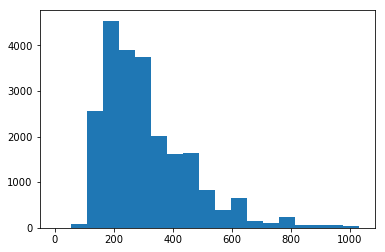

In [10]:
col = M.height
bins = np.linspace(0.0, col.quantile(0.99), num=20)
plt.hist(col, bins=bins);

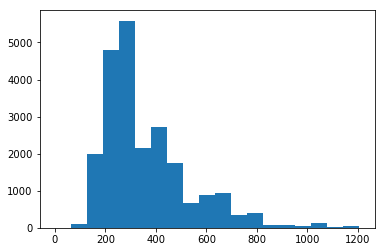

In [11]:
col = M.width
bins = np.linspace(0.0, col.quantile(0.99), num=20)
plt.hist(col, bins=bins);

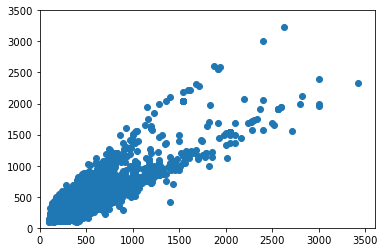

In [12]:
plt.scatter(M.width, M.height);
# not to show outliers
plt.xlim([0, 3600]);
plt.ylim([0, 3500]);

# Resize images

In [13]:
n_images = len(M)
n_images

22897

In [14]:
# new image shape: 64, 64
images = np.zeros((n_images, 64, 64, 3), dtype='uint8')
targets = np.zeros((n_images,), dtype='object')

In [15]:
# resize RGB images
for i, row in tqdm(M.loc[M.channels == 3].iterrows()):
    # get image and resize it
    file_path = os.path.join(dir_train, row.directory, row.img_name)
    image = Image.open(file_path).resize((64, 64), Image.NEAREST)
    # convert to array
    array = np.asarray(image, dtype='uint8')
    
    images[i] = array
    targets[i] = row.category_name

22599it [01:06, 341.58it/s]


In [16]:
# resize grayscale images
for i, row in tqdm(M.loc[M.channels == 1].iterrows()):
    file_path = os.path.join(dir_train, row.directory, row.img_name)
    image = Image.open(file_path).resize((64, 64), Image.NEAREST)
    array = np.asarray(image, dtype='uint8')
    # convert to RGB
    array = np.stack([array, array, array], axis=2)
    images[i] = array
    targets[i] = row.category_name

298it [00:00, 491.93it/s]


# Show some resized RGB images

In [17]:
# choose random images
to_show = np.random.choice(np.arange(0, n_images), size=2*4)

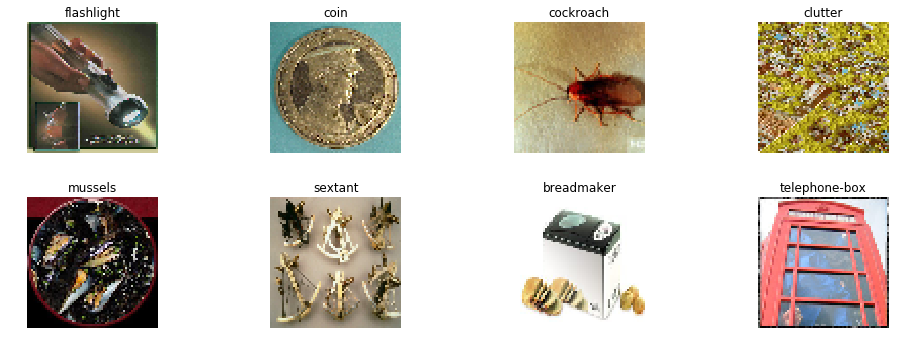

In [18]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 5))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(images[j]/255);
    axes[i].set_title(targets[j]);
plt.tight_layout()

# Show some resized grayscale images

In [19]:
gray_indices = list(M.loc[(M.channels == 1)].index)

In [20]:
to_show = np.random.choice(gray_indices, size=2*4)

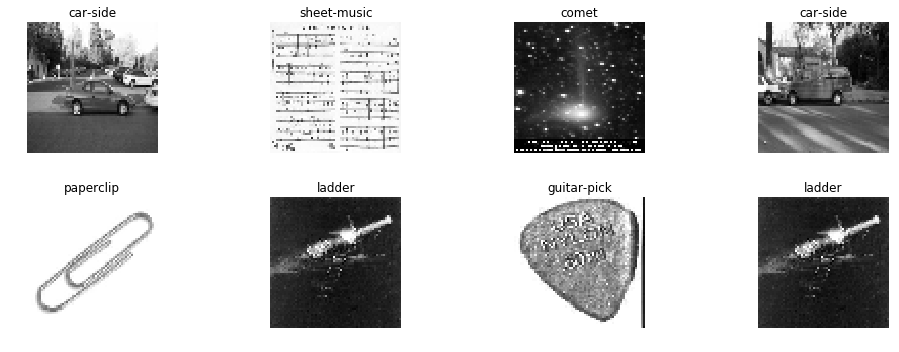

In [21]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 5))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(images[j]/255);
    axes[i].set_title(targets[j]);
plt.tight_layout()

# Save

In [22]:
np.save('images.npy', images) # size: 269 MB
np.save('targets.npy', targets)